# Densely Connected Networks (DenseNet)
ResNet significantly changed the view of how to parametrize the functions in deep networks. *DenseNet* (dense convolutional network) is to some extent the logical extension of this :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`.
DenseNet is characterized by both the connectivity pattern where
each layer connects to all the preceding layers
and the concatenation operation (rather than the addition operator in ResNet) to preserve and reuse features
from earlier layers.
To understand how to arrive at it, let's take a small detour to mathematics.


In [2]:
using Pkg; Pkg.activate("../../d2lai")
using d2lai
using Flux 
using CUDA, cuDNN

  Activating project at `/workspace/d2l-julia/d2lai`


## From ResNet to DenseNet

Recall the Taylor expansion for functions. At the point $x = 0$ it can be written as

$$f(x) = f(0) + x \cdot \left[f'(0) + x \cdot \left[\frac{f''(0)}{2!}  + x \cdot \left[\frac{f'''(0)}{3!}  + \cdots \right]\right]\right].$$


The key point is that it decomposes a function into terms of increasingly higher order. In a similar vein, ResNet decomposes functions into

$$f(\mathbf{x}) = \mathbf{x} + g(\mathbf{x}).$$

That is, ResNet decomposes $f$ into a simple linear term and a more complex
nonlinear one.
What if we wanted to capture (not necessarily add) information beyond two terms?
One such solution is DenseNet :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`.

![The main difference between ResNet (left) and DenseNet (right) in cross-layer connections: use of addition and use of concatenation. ](../img/densenet-block.svg)
:label:`fig_densenet_block`

As shown in :numref:`fig_densenet_block`, the key difference between ResNet and DenseNet is that in the latter case outputs are *concatenated* (denoted by $[,]$) rather than added.
As a result, we perform a mapping from $\mathbf{x}$ to its values after applying an increasingly complex sequence of functions:

$$\mathbf{x} \to \left[
\mathbf{x},
f_1(\mathbf{x}),
f_2\left(\left[\mathbf{x}, f_1\left(\mathbf{x}\right)\right]\right), f_3\left(\left[\mathbf{x}, f_1\left(\mathbf{x}\right), f_2\left(\left[\mathbf{x}, f_1\left(\mathbf{x}\right)\right]\right)\right]\right), \ldots\right].$$

In the end, all these functions are combined in MLP to reduce the number of features again. In terms of implementation this is quite simple:
rather than adding terms, we concatenate them. The name DenseNet arises from the fact that the dependency graph between variables becomes quite dense. The final layer of such a chain is densely connected to all previous layers. The dense connections are shown in :numref:`fig_densenet`.

![Dense connections in DenseNet. Note how the dimensionality increases with depth.](../img/densenet.svg)
:label:`fig_densenet`

The main components that comprise a DenseNet are *dense blocks* and *transition layers*. The former define how the inputs and outputs are concatenated, while the latter control the number of channels so that it is not too large, 
since the expansion $\mathbf{x} \to \left[\mathbf{x}, f_1(\mathbf{x}),
f_2\left(\left[\mathbf{x}, f_1\left(\mathbf{x}\right)\right]\right), \ldots \right]$ can be quite high-dimensional.


## Dense Blocks

DenseNet uses the modified "batch normalization, activation, and convolution"
structure of ResNet (see the exercise in :numref:`sec_resnet`).
First, we implement this convolution block structure.

In [4]:
struct DenseNetConvBlock{N} <: AbstractModel 
    net::N 
end 

Flux.@layer DenseNetConvBlock

(d::DenseNetConvBlock)(x) = d.net(x)

function DenseNetConvBlock(channel_in::Int, num_channels::Int)
    net = Chain(
        Conv((3,3), channel_in => num_channels, pad = 1),
        BatchNorm(num_channels, relu)
    )
end

DenseNetConvBlock

A *dense block* consists of multiple convolution blocks, each using the same number of output channels. In the forward propagation, however, we concatenate the input and output of each convolution block on the channel dimension. Lazy evaluation allows us to adjust the dimensionality automatically.

In [11]:
struct DenseBlock{N} <: AbstractModel 
    net::N 
end 
Flux.@layer DenseBlock

function DenseBlock(channel_in::Int, num_convs, num_channels; return_output_channels = false)
    prev_channels = channel_in
    conv_layers = map(1:num_convs) do i 
        block = DenseNetConvBlock(prev_channels, num_channels)
        prev_channels += num_channels 
        return block
    end
    net = DenseBlock(conv_layers)
    if return_output_channels
        return net, prev_channels 
    else 
        return net
    end
end

function (d::DenseBlock)(x)
    for block in d.net
        y = block(x)
        x = cat(x, y; dims = 3)
    end
    return x
end

In the following example,
we define a `DenseBlock` instance with two convolution blocks of 10 output channels.
When using an input with three channels, we will get an output with  $3 + 10 + 10=23$ channels. The number of convolution block channels controls the growth in the number of output channels relative to the number of input channels. This is also referred to as the *growth rate*.


In [12]:
block = DenseBlock(3, 2, 10)
block(rand(8,8,3,16)) |> size

(8, 8, 23, 16)

## Transition Layers

Since each dense block will increase the number of channels, adding too many of them will lead to an excessively complex model. A *transition layer* is used to control the complexity of the model. It reduces the number of channels by using a $1\times 1$ convolution. Moreover, it halves the height and width via average pooling with a stride of 2.


In [23]:
struct DenseNetTransitionBlock{N} <: AbstractModel 
    net::N
end
Flux.@layer DenseNetTransitionBlock

function DenseNetTransitionBlock(channel_in, num_channels)
    net = Chain(
        BatchNorm(channel_in, relu),
        Conv((1,1), channel_in => num_channels),
        MeanPool((2,2), pad = 1, stride = 2)
    )
end

(dtb::DenseNetTransitionBlock)(x) = dtb.net(x)

Apply a transition layer with 10 channels to the output of the dense block in the previous example.  This reduces the number of output channels to 10, and halves the height and width.


In [24]:
block = DenseNetTransitionBlock(23, 10)
block(rand(8, 8, 23, 16)) |> size

(5, 5, 10, 16)


## DenseNet Model

Next, we will construct a DenseNet model. DenseNet first uses the same single convolutional layer and max-pooling layer as in ResNet.


In [25]:
struct DenseNetB1{N} <: AbstractModel
    net::N 
end
Flux.@layer DenseNetB1
(b1::DenseNetB1)(x) = b1.net(x)

function DenseNetB1(channel_in::Int = 1)
    net = Chain(
        Conv((7,7), channel_in => 64, pad = 3, stride =2),
        BatchNorm(64, relu),
        MaxPool((3,3), stride = 2, pad = 1)
    )
    DenseNetB1(net)
end

DenseNetB1

Then, similar to the four modules made up of residual blocks that ResNet uses,
DenseNet uses four dense blocks.
As with ResNet, we can set the number of convolutional layers used in each dense block. Here, we set it to 4, consistent with the ResNet-18 model in :numref:`sec_resnet`. Furthermore, we set the number of channels (i.e., growth rate) for the convolutional layers in the dense block to 32, so 128 channels will be added to each dense block.

In ResNet, the height and width are reduced between each module by a residual block with a stride of 2. Here, we use the transition layer to halve the height and width and halve the number of channels. Similar to ResNet, a global pooling layer and a fully connected layer are connected at the end to produce the output.


In [34]:
struct DenseNet{N} <:AbstractClassifier
    net::N
end
Flux.@layer DenseNet 
(dn::DenseNet)(x) = dn.net(x)

function DenseNet(channel_in::Int = 1; growth_rate = 32, arch = (4,4,4,4), num_classes = 10)
    prev_channels = 64
    layers = []
    for i in 1:length(arch)
        block, prev_channels = DenseBlock(prev_channels, arch[i], growth_rate; return_output_channels = true)
        push!(layers, block)
        if i != length(arch)
            transition_layer = DenseNetTransitionBlock(prev_channels, prev_channels ÷ 2)
            prev_channels = prev_channels ÷ 2
            push!(layers, transition_layer)
        end
    end
    net = Flux.@autosize (96, 96, 1, 1) Chain(
        DenseNetB1(channel_in),
        layers...,
        GlobalMeanPool(),
        Flux.flatten,
        Dense(_ => num_classes),
        softmax

    )
    DenseNet(net)
end

DenseNet

In [35]:
model = DenseNet()


DenseNet(
  Chain(
    DenseNetB1(
      Chain(
        Conv((7, 7), 1 => 64, pad=3, stride=2),  # 3_200 parameters
        BatchNorm(64, relu),            # 128 parameters, plus 128
        MaxPool((3, 3), pad=1, stride=2),
      ),
    ),
    DenseBlock(
      [
        Chain(
          Conv((3, 3), 64 => 32, pad=1),  # 18_464 parameters
          BatchNorm(32, relu),          # 64 parameters, plus 64
        ),
        Chain(
          Conv((3, 3), 96 => 32, pad=1),  # 27_680 parameters
          BatchNorm(32, relu),          # 64 parameters, plus 64
        ),
        Chain(
          Conv((3, 3), 128 => 32, pad=1),  # 36_896 parameters
          BatchNorm(32, relu),          # 64 parameters, plus 64
        ),
        Chain(
          Conv((3, 3), 160 => 32, pad=1),  # 46_112 parameters
          BatchNorm(32, relu),          # 64 parameters, plus 64
        ),
      ],
    ),
    Chain(
      BatchNorm(192, relu),             # 384 parameters, plus 384
      Conv((1, 1), 192 => 9

## Training

Since we are using a deeper network here, in this section, we will reduce the input height and width from 224 to 96 to simplify the computation.


[ Info: Train Loss: 0.63423675, Val Loss: 0.44235954, Val Acc: 0.875
[ Info: Train Loss: 0.26092514, Val Loss: 0.35349703, Val Acc: 0.9375
[ Info: Train Loss: 0.23870032, Val Loss: 0.54305226, Val Acc: 0.8125
[ Info: Train Loss: 0.36317107, Val Loss: 0.43822515, Val Acc: 0.875
[ Info: Train Loss: 0.3757471, Val Loss: 0.3553314, Val Acc: 0.875
[ Info: Train Loss: 0.16658472, Val Loss: 0.48415565, Val Acc: 0.875
[ Info: Train Loss: 0.16947578, Val Loss: 0.3061001, Val Acc: 0.875
[ Info: Train Loss: 0.25147822, Val Loss: 0.4952318, Val Acc: 0.8125
[ Info: Train Loss: 0.14965303, Val Loss: 0.32668728, Val Acc: 0.875
[ Info: Train Loss: 0.14355798, Val Loss: 0.32147193, Val Acc: 0.875


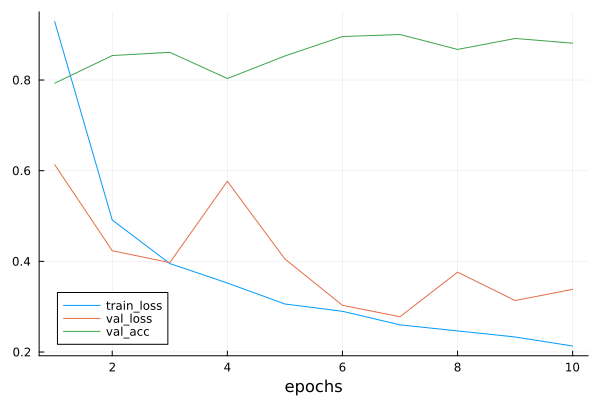

In [38]:
model = DenseNet()
data = d2lai.FashionMNISTData(batchsize = 128, resize = (96, 96))
opt = Descent(0.01)
trainer = Trainer(model, data, opt; max_epochs = 10, gpu = true, board_yscale = :identity)
d2lai.fit(trainer);

## Summary and Discussion

The main components that comprise DenseNet are dense blocks and transition layers. For the latter, we need to keep the dimensionality under control when composing the network by adding transition layers that shrink the number of channels again.
In terms of cross-layer connections, in contrast to ResNet, where inputs and outputs are added together, DenseNet concatenates inputs and outputs on the channel dimension.
Although these concatenation operations
reuse features to achieve computational efficiency,
unfortunately they lead to heavy GPU memory consumption.
As a result,
applying DenseNet may require more memory-efficient implementations that may increase training time :cite:`pleiss2017memory`.


## Exercises

1. Why do we use average pooling rather than max-pooling in the transition layer?
1. One of the advantages mentioned in the DenseNet paper is that its model parameters are smaller than those of ResNet. Why is this the case?
1. One problem for which DenseNet has been criticized is its high memory consumption.
    1. Is this really the case? Try to change the input shape to $224\times 224$ to compare the actual GPU memory consumption empirically.
    1. Can you think of an alternative means of reducing the memory consumption? How would you need to change the framework?
1. Implement the various DenseNet versions presented in Table 1 of the DenseNet paper :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`.
1. Design an MLP-based model by applying the DenseNet idea. Apply it to the housing price prediction task in :numref:`sec_kaggle_house`.


### 1 . 
Since the goal is to take outputs from previous layers upto the next layer, we use mean pooling. It doesnot discard the rest of the activations in the convolutional layer, and instead takes the mean.

### 2
Due to the transition layers, we effectively manage the model complexity and by extension the number of parameters.

### 3. 
A. 96x96 takes 2169MiB of GPU memoy. 224 / 96 = 2.33. The GPU memory is affected by the order of N^3. Therefore it will be 8 times more
B. Sparse Connectivity: Instead of connecting all the layers to all the layers, randomly pick some layers and connect them.
### 4. 

In [41]:
densenet121 = DenseNet(; arch = (6, 12, 24, 16))
densenet169 = DenseNet(; arch = (6, 12, 32, 32))
densenet201 = DenseNet(; arch = (6, 12, 48, 32))
densenet264 = DenseNet(; arch = (6, 12, 64, 48))

DenseNet(
  Chain(
    DenseNetB1(
      Chain(
        Conv((7, 7), 1 => 64, pad=3, stride=2),  # 3_200 parameters
        BatchNorm(64, relu),            # 128 parameters, plus 128
        MaxPool((3, 3), pad=1, stride=2),
      ),
    ),
    DenseBlock(
      [
        Chain(
          Conv((3, 3), 64 => 32, pad=1),  # 18_464 parameters
          BatchNorm(32, relu),          # 64 parameters, plus 64
        ),
        Chain(
          Conv((3, 3), 96 => 32, pad=1),  # 27_680 parameters
          BatchNorm(32, relu),          # 64 parameters, plus 64
        ),
        Chain(
          Conv((3, 3), 128 => 32, pad=1),  # 36_896 parameters
          BatchNorm(32, relu),          # 64 parameters, plus 64
        ),
        Chain(
          Conv((3, 3), 160 => 32, pad=1),  # 46_112 parameters
          BatchNorm(32, relu),          # 64 parameters, plus 64
        ),
        Chain(
          Conv((3, 3), 192 => 32, pad=1),  # 55_328 parameters
          BatchNorm(32, relu),          # 6

### 5.

In [ ]:
## 5.
struct DenseNetMLPBlock{N} <: AbstractModel 
    net::N 
end 

function DenseNetMLPBlock(features_in, num_features, num_dense, return_output_features = false)
    prev_features = features_in
    blocks = []
    for i in 1:num_dense
        push!(blocks, Dense(prev_features, num_features))
        prev_features += num_features
        push!(blocks, Dropout(0.4),
    end
    block = DenseNetMLPBlock(blocks)
    if return_output_features 
        return block, prev_features 
    else
        return block
    end
            
end

function (d::DenseNetMLPBlock)(x)
    for block in d.net
        y = block(x)
        x = vcat(x,y)
    end
end

struct DenseNetMLP{N} <: AbstractModel 
    net::N
end


In [ ]:
function DenseNetMLP(num_features; num_classes = 10, arch = (4,4,4,4))
    prev_features = 64
    layers = map(arch) do num_dense 
        block, prev_features = DenseNetMLPBlock(prev_features, 64, num_dense; return_output_featuers = true)
        return block
    end
    Chain(
        Dense(num_features => 64, relu),
        Dropout(0.2),
        layers...,
        Dense(_ => num_classes),
        softmax
    )
end